TensorFlow version: 2.19.0
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train shape: (60000, 784)
Test  shape: (10000, 784)
Final Train: (50000, 784) Validation: (10000, 784) Test: (10000, 784)

Training Run A (seed=1)
Run A - Test accuracy: 0.8762, Test loss: 0.4239

Training Run B (seed=2)
Run B - Test accuracy: 0.8782, Test loss: 0.4333


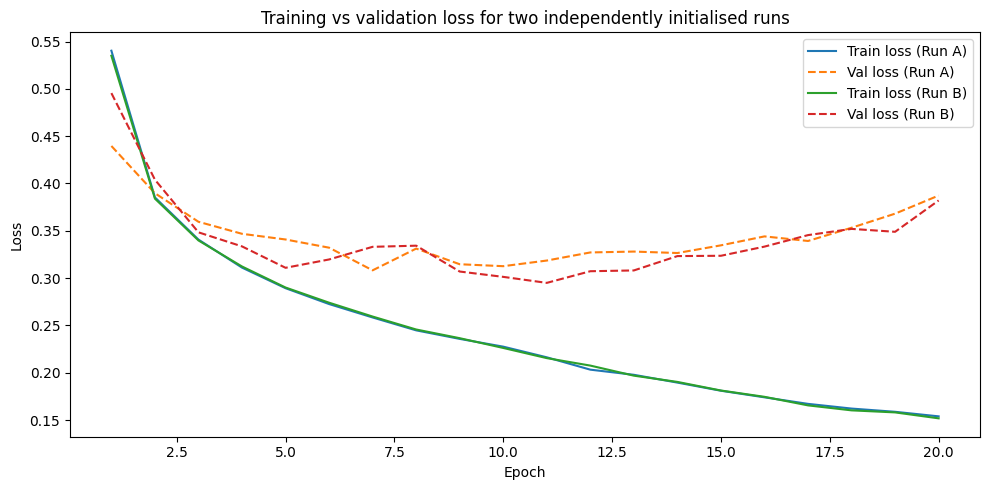

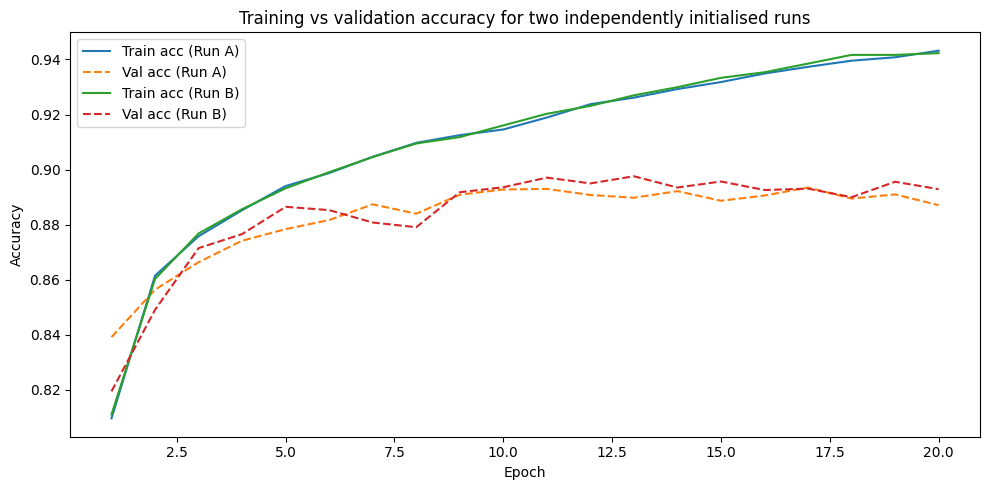


Evaluating interpolated models along the weight-space path...
alpha=0.00 | train_loss=0.2026, val_loss=0.3873
alpha=0.05 | train_loss=0.2023, val_loss=0.3642
alpha=0.10 | train_loss=0.2190, val_loss=0.3624
alpha=0.15 | train_loss=0.2787, val_loss=0.3811
alpha=0.20 | train_loss=0.3298, val_loss=0.4196
alpha=0.25 | train_loss=0.4080, val_loss=0.4772
alpha=0.30 | train_loss=0.5188, val_loss=0.5571
alpha=0.35 | train_loss=0.6335, val_loss=0.6622
alpha=0.40 | train_loss=0.7644, val_loss=0.7851
alpha=0.45 | train_loss=0.8696, val_loss=0.8943
alpha=0.50 | train_loss=0.9265, val_loss=0.9412
alpha=0.55 | train_loss=0.8836, val_loss=0.9018
alpha=0.60 | train_loss=0.7712, val_loss=0.7950
alpha=0.65 | train_loss=0.6243, val_loss=0.6610
alpha=0.70 | train_loss=0.4996, val_loss=0.5381
alpha=0.75 | train_loss=0.3819, val_loss=0.4446
alpha=0.80 | train_loss=0.3161, val_loss=0.3845
alpha=0.85 | train_loss=0.2628, val_loss=0.3524
alpha=0.90 | train_loss=0.2176, val_loss=0.3428
alpha=0.95 | train_loss=0

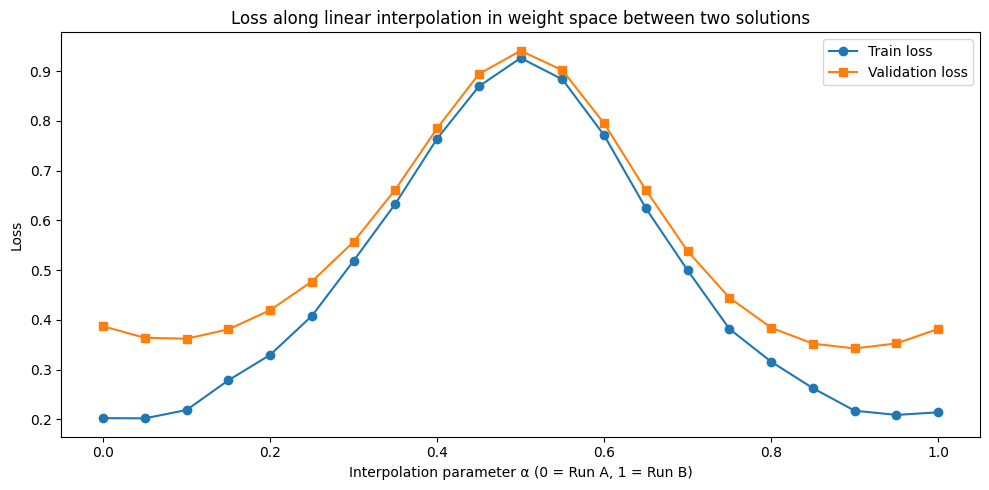

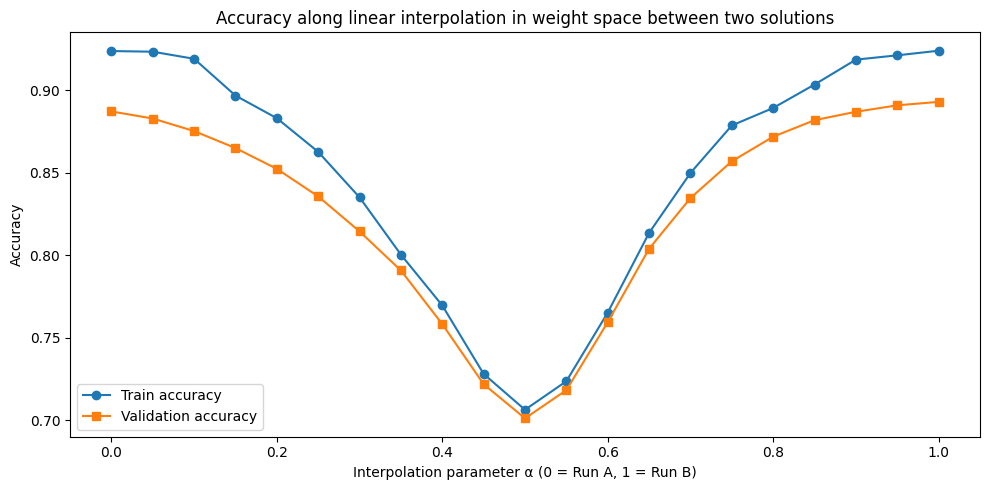


=== SUMMARY OF FINAL TEST PERFORMANCE ===
Run      | Test Acc | Test Loss
-------------------------------------
Run A    | 0.8762   | 0.4239
Run B    | 0.8782   | 0.4333

Saved figures:
 - loss_curves_runs.png
 - accuracy_curves_runs.png
 - loss_landscape_interpolation.png
 - accuracy_landscape_interpolation.png


In [1]:
# ============================================================
# Loss Landscape Geometry via Weight Interpolation
# - Dataset: Fashion-MNIST
# - Model: Simple MLP
# - Two independent runs (different seeds)
# - Interpolate between solutions in weight space and evaluate loss
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------------------------------------------------------------------
# 1. Set up reproducibility & basic utilities
# -------------------------------------------------------------------
def set_global_seed(seed):
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism = False  # may be ignored depending on TF build

set_global_seed(42)

print("TensorFlow version:", tf.__version__)

# -------------------------------------------------------------------
# 2. Load and preprocess Fashion-MNIST
# -------------------------------------------------------------------
(fx_train, fy_train), (fx_test, fy_test) = keras.datasets.fashion_mnist.load_data()

# Normalize to [0,1] and flatten
fx_train = fx_train.astype("float32") / 255.0
fx_test  = fx_test.astype("float32") / 255.0
fx_train = fx_train.reshape((fx_train.shape[0], -1))
fx_test  = fx_test.reshape((fx_test.shape[0], -1))

print("Train shape:", fx_train.shape)
print("Test  shape:", fx_test.shape)

# Split train into train + validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    fx_train, fy_train, test_size=10000, random_state=42, stratify=fy_train
)

print("Final Train:", X_train.shape, "Validation:", X_val.shape, "Test:", fx_test.shape)

# -------------------------------------------------------------------
# 3. Model builder
# -------------------------------------------------------------------
def build_mlp(input_dim=784, num_classes=10):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# -------------------------------------------------------------------
# 4. Train two models with different seeds
# -------------------------------------------------------------------
def train_run(run_name, seed):
    print(f"\n==============================")
    print(f"Training {run_name} (seed={seed})")
    print("==============================")
    set_global_seed(seed)
    model = build_mlp()
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=128,
        validation_data=(X_val, y_val),
        verbose=0
    )
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(fx_test, fy_test, verbose=0)
    print(f"{run_name} - Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")
    return model, history, test_loss, test_acc

model_A, hist_A, test_loss_A, test_acc_A = train_run("Run A", seed=1)
model_B, hist_B, test_loss_B, test_acc_B = train_run("Run B", seed=2)

# -------------------------------------------------------------------
# 5. Plot training & validation curves
# -------------------------------------------------------------------
epochs = range(1, len(hist_A.history["loss"]) + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs, hist_A.history["loss"], label="Train loss (Run A)", linestyle="-")
plt.plot(epochs, hist_A.history["val_loss"], label="Val loss (Run A)", linestyle="--")
plt.plot(epochs, hist_B.history["loss"], label="Train loss (Run B)", linestyle="-")
plt.plot(epochs, hist_B.history["val_loss"], label="Val loss (Run B)", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs validation loss for two independently initialised runs")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curves_runs.png", dpi=300)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs, hist_A.history["accuracy"], label="Train acc (Run A)", linestyle="-")
plt.plot(epochs, hist_A.history["val_accuracy"], label="Val acc (Run A)", linestyle="--")
plt.plot(epochs, hist_B.history["accuracy"], label="Train acc (Run B)", linestyle="-")
plt.plot(epochs, hist_B.history["val_accuracy"], label="Val acc (Run B)", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs validation accuracy for two independently initialised runs")
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_curves_runs.png", dpi=300)
plt.show()

# -------------------------------------------------------------------
# 6. Loss landscape via interpolation in weight space
# -------------------------------------------------------------------
# Get weights from both trained models
weights_A = model_A.get_weights()
weights_B = model_B.get_weights()

def interpolate_weights(weights1, weights2, alpha):
    """Interpolate between two sets of weights."""
    return [(1 - alpha) * w1 + alpha * w2 for w1, w2 in zip(weights1, weights2)]

# Build a fresh model with same architecture for evaluation
eval_model = build_mlp()

alphas = np.linspace(0.0, 1.0, 21)  # 21 points between Run A and Run B
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("\nEvaluating interpolated models along the weight-space path...")
for alpha in alphas:
    # Interpolate weights and set them
    interp_w = interpolate_weights(weights_A, weights_B, alpha)
    eval_model.set_weights(interp_w)

    # Evaluate on a subset of train for speed (e.g., 10,000 samples)
    subset_idx = np.random.choice(len(X_train), size=min(10000, len(X_train)), replace=False)
    X_train_sub = X_train[subset_idx]
    y_train_sub = y_train[subset_idx]

    train_loss, train_acc = eval_model.evaluate(X_train_sub, y_train_sub, verbose=0)
    val_loss, val_acc     = eval_model.evaluate(X_val, y_val, verbose=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"alpha={alpha:.2f} | train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

# -------------------------------------------------------------------
# 7. Plot loss landscape along interpolation
# -------------------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(alphas, train_losses, marker="o", label="Train loss")
plt.plot(alphas, val_losses, marker="s", label="Validation loss")
plt.xlabel("Interpolation parameter α (0 = Run A, 1 = Run B)")
plt.ylabel("Loss")
plt.title("Loss along linear interpolation in weight space between two solutions")
plt.legend()
plt.tight_layout()
plt.savefig("loss_landscape_interpolation.png", dpi=300)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(alphas, train_accs, marker="o", label="Train accuracy")
plt.plot(alphas, val_accs, marker="s", label="Validation accuracy")
plt.xlabel("Interpolation parameter α (0 = Run A, 1 = Run B)")
plt.ylabel("Accuracy")
plt.title("Accuracy along linear interpolation in weight space between two solutions")
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_landscape_interpolation.png", dpi=300)
plt.show()

# -------------------------------------------------------------------
# 8. Simple text summary table
# -------------------------------------------------------------------
print("\n=== SUMMARY OF FINAL TEST PERFORMANCE ===")
print(f"{'Run':8s} | {'Test Acc':8s} | {'Test Loss':9s}")
print("-------------------------------------")
print(f"{'Run A':8s} | {test_acc_A:.4f}   | {test_loss_A:.4f}")
print(f"{'Run B':8s} | {test_acc_B:.4f}   | {test_loss_B:.4f}")

print("\nSaved figures:")
print(" - loss_curves_runs.png")
print(" - accuracy_curves_runs.png")
print(" - loss_landscape_interpolation.png")
print(" - accuracy_landscape_interpolation.png")
